# <center> Identify online patient conversations </center>
## Approach: Embedding + LSTM

### Import libraries

In [26]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display, SVG
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import nltk
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

### Include ROC AUC as metric in Keras

In [22]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

### Shuffle data to avoid bias while training

In [23]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

### Initialize objects

In [6]:
seed = 8
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

le = LabelEncoder()

In [7]:
SOURCE_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'Models_and_output/'

### Read train and test data

In [8]:
train_data = pd.read_csv(SOURCE_FOLDER + 'train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv(SOURCE_FOLDER + 'test.csv', encoding='utf8')
test_data = test_data[test_data.columns[1:-1]]

In [9]:
train_data.head()

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,6/15/2016,13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,5/7/2016,0.820833333,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,4/14/2016,15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,6/18/2016,20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,6/15/2016,3:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0


### Consider only 'TRANS_CONV_TEXT' column for predictions

In [10]:
train_data = train_data[train_data['TRANS_CONV_TEXT'].notnull()]

### Imbalanced dataset

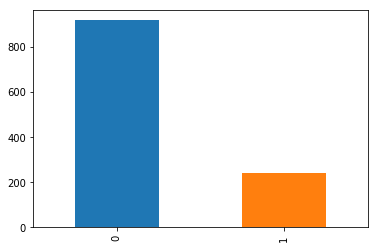

In [11]:
train_data.Patient_Tag.value_counts().plot('bar')

In [12]:
X_train = train_data['TRANS_CONV_TEXT']
Y_train = train_data['Patient_Tag']
Y_train = to_categorical(Y_train)

### Preprocess text
- Remove punctuations from data.
- Apply lemmatization on words. Convert each word to its lemma.

In [13]:
def preprocess_data(X_train, stemmer, lemma):
    preprocessed_data = []
    trans = str.maketrans('/(){}', ' ' * 5)
    trans_punc = str.maketrans('', '', string.punctuation)

    for text in X_train:
        text = text.lower().translate(trans)
        text = text.translate(trans_punc)
        text = [lemma.lemmatize(word) for word in text.split()]
        preprocessed_data.append(' '.join(text))

    return preprocessed_data

In [14]:
preprocessed_data = preprocess_data(X_train, stemmer, lemma)

In [15]:
preprocessed_data[-1]

'i went through a sleep study ahi severe at 95 and titration test in late 2011 but wa never able to sleep effectively i own the system one series 50 650 bipap pro that i wa prescribed and an opus 360 nasal pillow assembly both are essentially unused im about 20 pound lighter than i wa back then and my sleeping seems to be a little bit better now than it wa back then whats the best way of trying to address my sleep apnea again is it ok to just try my existing machine and setting and adjust using sleepyhead do i need to go back to the doc and or do another sleep study are there any particularly good mask since 2011 that might be better than what i have ive spent the last three week dealing with a father with congestive heart failure and id like to try and do what i can to avoid that'

### Tokenize text
- Tokenize text and convert them into integers

In [18]:
t = Tokenizer()
t.fit_on_texts(preprocessed_data)
encoded_lines = t.texts_to_sequences(preprocessed_data)

### Initialize variables

In [19]:
number_of_words = len(t.word_index) + 1
max_length_of_input = 1000
embedding_vector_length = 32

### Pad sequences to same length and split data to form validation set

In [20]:
X_train = sequence.pad_sequences(encoded_lines, max_length_of_input)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed)

### Create an LSTM network

In [36]:
model = Sequential()
model.add(Embedding(number_of_words, embedding_vector_length, input_length = max_length_of_input))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(2, activation = 'softmax'))

### Compile and fit the model

In [28]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[auc_pr, 'accuracy'])

mc = keras.callbacks.ModelCheckpoint('weights{epoch:02d}.h5', 
                                     save_weights_only=True, period=5)

# Try 40 epochs
model.fit_generator(generator=batch_generator_shuffle(X_train, y_train, 32),
                      epochs=5, validation_data=(X_valid, y_valid),
                      steps_per_epoch=X_train.shape[0] / 32, callbacks=[mc])

scores = model.evaluate(X_valid, y_valid)
print ('\n')
print (scores)

Epoch 1/5
25/24 [===============================] - 40s 2s/step - loss: 0.5824 - auc_pr: 0.7130 - acc: 0.7795 - val_loss: 0.5073 - val_auc_pr: 0.7588 - val_acc: 0.8063
Epoch 2/5
25/24 [===============================] - 38s 2s/step - loss: 0.4682 - auc_pr: 0.7880 - acc: 0.7870 - val_loss: 0.4163 - val_auc_pr: 0.8113 - val_acc: 0.8063
Epoch 3/5
25/24 [===============================] - 38s 2s/step - loss: 0.2288 - auc_pr: 0.8532 - acc: 0.9024 - val_loss: 0.2552 - val_auc_pr: 0.8879 - val_acc: 0.8848
Epoch 4/5
25/24 [===============================] - 43s 2s/step - loss: 0.0755 - auc_pr: 0.9109 - acc: 0.9837 - val_loss: 0.2670 - val_auc_pr: 0.9274 - val_acc: 0.9084
Epoch 5/5
382/382 [==============================] - 3s 8ms/step


[0.3576499744859665, 0.9451076506944227, 0.8952879593634481]


### Preprocess test data and convert into vector form 

In [30]:
X_test = test_data['TRANS_CONV_TEXT']
X_test = preprocess_data(X_test, stemmer, lemma)
X_test = t.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, max_length_of_input)

In [32]:
X_test.shape

(571, 1000)

### Predict output and save predictions

In [38]:
output = model.predict(X_test, 32)

patient_tag = np.argmax(output, axis=1)
index = list(range(1, len(output)+1))
test_data_df = pd.DataFrame({'Index': index,'Patient_Tag': patient_tag}).set_index('Index')
test_data_df.Patient_Tag = test_data_df.Patient_Tag.astype('int')
test_data_df.to_csv('Approach_2_output.csv', columns=['Patient_Tag'])